In [4]:
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import numpy as np
import pandas as pd

from pic_parser.utils import cell_to_array

DB = "E:/Dropbox/SPEED/Self Driving EHD/Data/10-Mar-2022 large nozzle mosaic/logs/measurements.xlsx"
DB = "E:/Dropbox/SPEED/Self Driving EHD/Data/29-Mar-2022 lg 1cm 300 points/logs/measurements.xlsx"
df = pd.read_excel(DB, index_col=0)

features = ['absintegral', 'absmax', 'vmag', 'bias', 'maxcumsum']
F = np.array(df[features])

X = np.array([cell_to_array(x) for x in df.vector])
Y = np.array(df.area)

# for i in df.index:
#     df.wave.loc[i] = cell_to_array(df.wave.loc[i])

In [6]:
# Initialize some ML kit
from scipy.stats import linregress

from sklearn import metrics
from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor


def calc_auc(Y, Y_true):
    thresh = 0
    auc = metrics.roc_auc_score(Y_true > thresh,
                                Y > thresh)
    return auc


def calc_mae(Y, Y_true):
    mae = np.abs(Y - Y_true).mean()
    return mae


def calc_mse(Y, Y_true):
    mse = ((Y - Y_true)**2).mean()
    return mse


def calc_r_val(Y, Y_true):
    # slope, intercept, r_value, p_value, std_err
    _, _, r_value, _, _ = linregress(Y, Y_true)
    return r_value


def norm(x):
    mean = x.mean(0)
    std = x.std(0)
    return (x - mean)/std, mean, std


class MLE_Regressor():
    def __init__(self):
        self.answers = None
    def fit(self, X, Y):
        self.answers = Y.mean(0)
    def predict(self, X):
        '''Unpredictable for multiple X!'''
        return self.answers


def LOO(X, Y, model, plot=False):
    N = Y.shape[0]
    guesses = np.zeros(Y.shape)
    for i in range(N):
        trainset = np.arange(N) != i
        X_train = X[trainset, :]
        Y_train = Y[trainset]
        # TODO stop overfitting!:
        # X_train = X
        # Y_train = Y
        model.fit(X_train, Y_train)
        guesses[i] = model.predict(X[i][None, :])
    if plot:
        plt.plot(Y, guesses, '*'); plt.xlabel('truth'); plt.ylabel('prediction')
#         plt.savefig('sin coef best model.png')
#         plt.savefig('custom feat best model.png')
        plt.show()
    return calc_mae(Y, guesses), calc_mse(Y, guesses), calc_r_val(Y, guesses), calc_auc(Y, guesses)


def eval_N_folds(X, Y, model, plot=False, N=10):
    kf = KFold(n_splits=N, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X):
        # TODO

Y, mean, std = norm(Y)

Training MLE...
MLE mae: 0.8297   mse: 1.0072   r: -1.0000   auc: 0.0000

Training KNN...
KNN mae: 0.6799   mse: 0.8682   r: 0.4106   auc: 0.6717

Training Ridge...
Ridge mae: 0.8240   mse: 1.0218   r: 0.0322   auc: 0.5721

Training Kernel...
Kernel mae: 0.8251   mse: 1.0144   r: 0.0506   auc: 0.5478

Training Random Forest...
Random Forest LOO results:


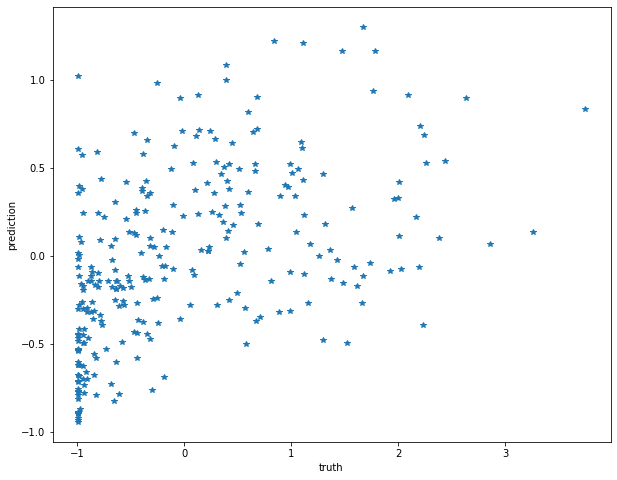

Random Forest mae: 0.6583   mse: 0.7593   r: 0.4907   auc: 0.7025

Training MLP...
MLP mae: 0.6877   mse: 0.7923   r: 0.5368   auc: 0.7474



In [7]:
results = pd.DataFrame(columns=('model', 'mae', 'mse', 'r', 'auc'))
models = {'MLE': MLE_Regressor(),
         'KNN': KNeighborsRegressor(),
         'Ridge': Ridge(),
         'Kernel': KernelRidge(),
         'Random Forest': RandomForestRegressor(),
         'MLP': MLPRegressor(max_iter=2000)}
best = 'Random Forest'

for label, model in models.items():
    print(f'Training {label}...')
    if label == best:
        print(f'{label} LOO results:')
        mae, mse, r_val, auc = LOO(X, Y, model, plot=True)
    else:
        mae, mse, r_val, auc = LOO(X, Y, model)
    print(f'{label} mae: {mae:.4f}   mse: {mse:.4f}   r: {r_val:.4f}   auc: {auc:.4f}', end='\n\n')
    results = results.append({'model': label, 'mae': mae, 'mse': mse, 'r': r_val, 'auc': auc},
                             ignore_index=True)
results.to_excel('training_summary.xlsx')

Training MLE...
MLE mae: 0.8297   mse: 1.0072   r: -1.0000   auc: 0.0000

Training KNN...
KNN mae: 0.7480   mse: 0.9361   r: 0.3633   auc: 0.6007

Training Ridge...
Ridge LOO results:


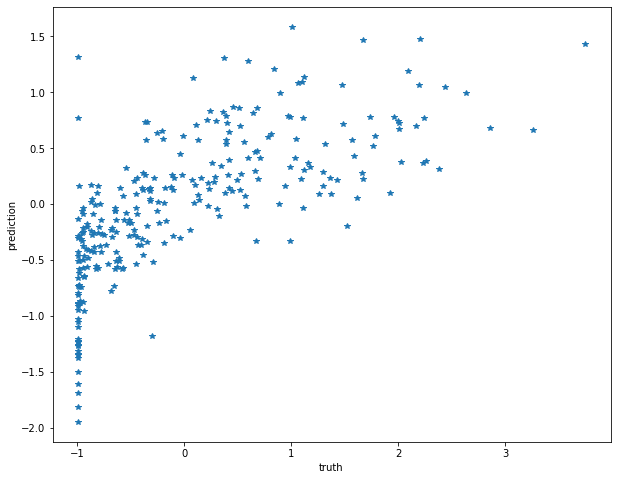

Ridge mae: 0.5491   mse: 0.5196   r: 0.6955   auc: 0.8255

Training Kernel...
Kernel mae: 0.7870   mse: 0.9081   r: 0.3254   auc: 0.5914

Training Random Forest...
Random Forest mae: 0.4858   mse: 0.4700   r: 0.7319   auc: 0.8463

Training MLP...
MLP mae: 0.7299   mse: 0.9387   r: 0.3423   auc: 0.6748



In [8]:
results = pd.DataFrame(columns=('model', 'mae', 'mse', 'r', 'auc'))
models = {'MLE': MLE_Regressor(),
         'KNN': KNeighborsRegressor(),
         'Ridge': Ridge(),
         'Kernel': KernelRidge(),
         'Random Forest': RandomForestRegressor(),
         'MLP': MLPRegressor(max_iter=2000)}
best = 'Ridge'

for label, model in models.items():
    print(f'Training {label}...')
    if label == best:
        print(f'{label} LOO results:')
        mae, mse, r_val, auc = LOO(F, Y, model, plot=True)
    else:
        mae, mse, r_val, auc = LOO(F, Y, model)
    print(f'{label} mae: {mae:.4f}   mse: {mse:.4f}   r: {r_val:.4f}   auc: {auc:.4f}', end='\n\n')
    results = results.append({'model': label, 'mae': mae, 'mse': mse, 'r': r_val, 'auc': auc},
                             ignore_index=True)
results.to_excel('training_summary_customfeat.xlsx')

Training MLE...
MLE mae: 0.8297   mse: 1.0072   r: -1.0000   auc: 0.0000

Training KNN...
KNN mae: 0.7427   mse: 0.9496   r: 0.3532   auc: 0.6092

Training Ridge...
Ridge mae: 0.5563   mse: 0.5335   r: 0.6842   auc: 0.8224

Training Kernel...
Kernel mae: 0.7829   mse: 0.9196   r: 0.3020   auc: 0.6134

Training Random Forest...
Random Forest LOO results:


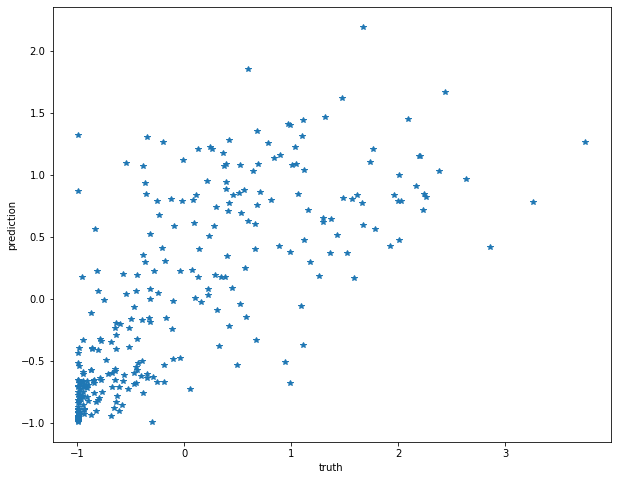

Random Forest mae: 0.4910   mse: 0.4695   r: 0.7301   auc: 0.8383

Training MLP...
MLP mae: 0.7605   mse: 0.9830   r: 0.2921   auc: 0.6690



In [9]:
results = pd.DataFrame(columns=('model', 'mae', 'mse', 'r', 'auc'))
models = {'MLE': MLE_Regressor(),
         'KNN': KNeighborsRegressor(),
         'Ridge': Ridge(),
         'Kernel': KernelRidge(),
         'Random Forest': RandomForestRegressor(),
         'MLP': MLPRegressor(max_iter=2000)}
best = 'Random Forest'

G = np.concatenate((X, F), 1)

for label, model in models.items():
    print(f'Training {label}...')
    if label == best:
        print(f'{label} LOO results:')
        mae, mse, r_val, auc = LOO(G, Y, model, plot=True)
    else:
        mae, mse, r_val, auc = LOO(G, Y, model)
    print(f'{label} mae: {mae:.4f}   mse: {mse:.4f}   r: {r_val:.4f}   auc: {auc:.4f}', end='\n\n')
    results = results.append({'model': label, 'mae': mae, 'mse': mse, 'r': r_val, 'auc': auc},
                             ignore_index=True)
results.to_excel('training_summary_combinedfeat.xlsx')